An attempt at reproducing the work from https://github.com/bscellier/Towards-a-Biologically-Plausible-Backprop/tree/master?tab=readme-ov-file. For some reason this doesn't converge, still haven't gotten to the bottom of it. I can converge when shown one sample repeatedly, but not on the whole.

![CleanShot 2025-01-12 at 23.16.39@2x.png](<attachment:CleanShot 2025-01-12 at 23.16.39@2x.png>)
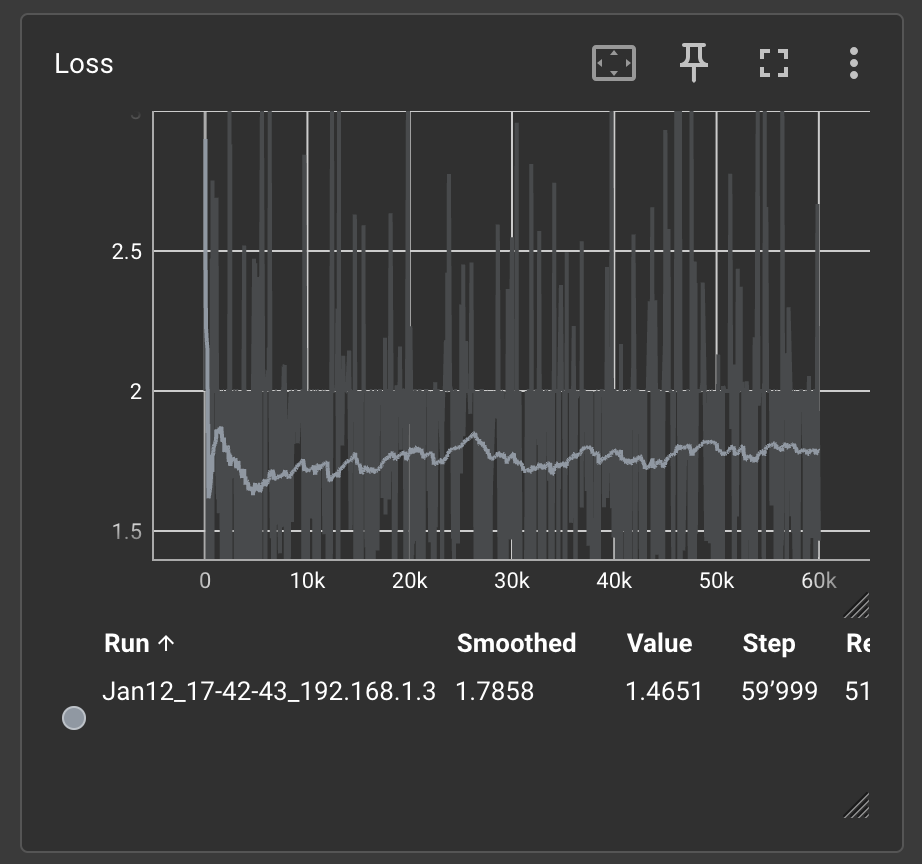

In [51]:
import jax.numpy as jnp
import jax
import tensorflow
from tensorboardX import SummaryWriter


layer_sizes = (784, 500, 10)

key = jax.random.key(1)

weights = [
    jax.random.uniform(k, (layer_sizes[i], layer_sizes[i+1]), minval=-jnp.sqrt(6/(layer_sizes[i]+ layer_sizes[i+1])), maxval=jnp.sqrt(6/(layer_sizes[i]+ layer_sizes[i+1]))) for i, k in enumerate(jax.random.split(key, len(layer_sizes)-1))
]
biases = [
    jnp.zeros((layer_sizes[i])) for i in range(0, len(layer_sizes))
]

print(f"Sets of weights: {len(weights)}, shapes: {' '.join([str(x.shape) for x in weights])}")
print(f"Sets of biases: {len(biases)}, shapes: {' '.join([str(x.shape) for x in biases])}")

@jax.jit
def rho(x):
    return jax.nn.hard_sigmoid(x)

@jax.jit
def energy(x, h, y, biases, weights):
    layers = (x, h, y)
    squared_norm = 0.5 * sum([jnp.linalg.norm(rho(layer)) ** 2 for layer in layers])
    linear_terms = - sum([jnp.dot(rho(layer), b) for layer, b in zip(layers, biases)])
    quadratic_terms = - sum([jnp.dot(jnp.dot(rho(pre), W), rho(post)) for pre, W, post in zip(layers[:-1], weights, layers[1:])])
    return squared_norm + linear_terms + quadratic_terms

@jax.jit
def cost(y, target):
    return jnp.sum((y - target) ** 2)

@jax.jit
def total_energy(x, h, y, target, beta, biases, weights):
    return energy(x, h, y, biases, weights) + beta * cost(y, target)

def measure(x, h, y, target):
    E = energy(x, h, y)
    C = cost(y, target)
    y_pred = jnp.argmax(y)
    error = jnp.not_equal(y_pred, target)

    return E, C, error


n_epochs = 100
batch_size = 25
n_it_neg = 40
n_it_pos = 8
epsilon = 0.5
beta = 1
alphas = 0.1, 0.05


#Fetch MNIST dataset from the ~SOURCE~
def fetch_MNIST():

    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
    # print(x_train) 
    x_train = jnp.reshape(x_train, (-1, 784)) / 255
    # x_test = jnp.expand_dims(x_test, -1)
    return x_train, jax.nn.one_hot(y_train[:100], 10, axis=-1)

x_train, y_train = fetch_MNIST()
# writer = SummaryWriter()

for epoch in range(n_epochs):
    # print("Hi")
    for i in range(0, batch_size, batch_size):
        print(i)
        new_biases, new_weights = [], []
        batch = zip(x_train[i: i + batch_size], y_train[i: i + batch_size])

        # batch = zip(x_train[:2], y_train[:2])
        for j, (input, target) in enumerate(batch):
            key, k = jax.random.split(key)
            print(target)
            beta = beta * (2*jax.random.bernoulli(k, 0.5) - 1)
            x = input
            k1, k2, key = jax.random.split(key, 3)
            # h = jax.random.uniform(k1, layer_sizes[1:-1])
            # y = jax.random.uniform(k2, layer_sizes[-1])
            h = jnp.zeros(layer_sizes[1:-1])
            y = jnp.zeros(layer_sizes[-1])
            
            def free_phase(x, h, y):
                def step(x, h, y):
                    h_dot, y_dot = jax.grad(energy, argnums=[1, 2])(x, h, y, biases, weights)
                    h, y = jnp.clip(h + epsilon * -h_dot, 0, 1), jnp.clip(y + epsilon * -y_dot, 0, 1)
                    # print(energy(x, h, y, biases, weights))
                    return x, h, y
                
                for _ in range(n_it_neg):
                    x, h, y = step(x, h, y)

                return x, h, y

            def nudge_phase(x, h, y, target):
                def step(x, h, y, target):
                    h_dot, y_dot = jax.grad(total_energy, argnums=[1, 2])(x, h, y, target, beta, biases, weights)
                    h, y = jnp.clip(h + epsilon * -h_dot, 0, 1), jnp.clip(y + epsilon * -y_dot, 0, 1)
                    return x, h, y, target

                for _ in range(n_it_pos):
                    x, h, y, target = step(x, h, y, target)
                
                return x, h, y, target

            x, h, y = free_phase(x, h, y)
            x1, h1, y1, target = nudge_phase(x, h, y, target)

            def boop(x, h, y, x1, h1, y1, beta, biases, weights):
                return (energy(x1, h1, y1, biases, weights) - energy(x, h, y, biases, weights))/beta

            biases_dot = jax.grad(boop, argnums=7)(x, h, y, x1, h1, y1, beta, biases, weights)
            weights_dot = jax.grad(boop, argnums=8)(x, h, y, x1, h1, y1, beta, biases, weights)

            if len(new_biases) == 0:
                    
                new_biases = [b - alpha * dot for b, alpha, dot in zip(biases[1:], alphas, biases_dot[1:])]
                new_weights = [W - alpha * dot for W, alpha, dot in zip(weights, alphas, weights_dot)]
            else:
                new_biases = [old_b + b - alpha * dot for b, alpha, dot, old_b in zip(biases[1:], alphas, biases_dot[1:], new_biases)]
                new_weights = [old_w + W - alpha * dot for W, alpha, dot, old_w in zip(weights, alphas, weights_dot, new_weights)]

            # x2, h2, y2 = free_phase(x, h, y)

            print(f"Cost between y and target: {cost(y, target)}")
            # writer.add_scalar("Loss", cost(y, target), j+i+len(x_train)*epoch)

        biases[1:] = [b/batch_size for b in new_biases]
        weights = [w/batch_size for w in new_weights]


Sets of weights: 2, shapes: (784, 500) (500, 10)
Sets of biases: 3, shapes: (784,) (500,) (10,)
0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Cost between y and target: 2.6662187576293945
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cost between y and target: 2.66347074508667
0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Cost between y and target: 1.3231289386749268
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cost between y and target: 1.2985970973968506
0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Cost between y and target: 1.0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cost between y and target: 1.0
0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Cost between y and target: 1.3936911821365356
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cost between y and target: 0.1127353385090828
0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Cost between y and target: 1.6818926334381104
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cost between y and target: 0.02478679269552231
0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Cost between y and target: 1.16465425491333
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cost between y and target: 0.154648

KeyboardInterrupt: 

Why is there rho in the squared term ??!?!?

In [ ]:
import ipytest
ipytest.autoconfig()

def test_descent():
    starting_energy = energy(x, h, y, biases, weights)
    x1, h1, y1 = free_phase(x, h, y)
    ending_energy = energy(x1, h1, y1, biases, weights)
    assert ending_energy < starting_energy


ipytest.run()